Here is a useful tool to chose your targets for your proposals and prepare your nights observations.

In [51]:
# Some useful libraries
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter,HourLocator
from astropy.coordinates import get_sun

# Choose Location

We will give an example with the Southern Astrophysical Research Telescope (SOAR)

In [2]:
# Observatory location
soar_location = EarthLocation(lat=-30.2407*u.deg, lon=-70.7366*u.deg, height=2738*u.m)

# Choose stars

## List them here

In [65]:
# Star list
stars_data = [
    ("TIC 3888273",     10.941625,   -10.006889),
    ("TIC 46199750",   234.145500,    -5.877750),
    ("TIC 88564975",   106.698297,    61.563914),
    ("TIC 103222871",   63.192713,    75.828518),
    ("TIC 380174982",  259.217042,   -59.110081),
    ("TIC 437042755",  134.078917,    16.184328),
    ("TIC 471013585",   58.315580,     9.942615),
    ("TIC 610754879",   19.543087,    -1.936773),
    ("TIC 649932200",   58.315466,     9.942724),
    ("TIC 950570354",  195.146666,    59.070998),
    ("TIC 952264940",  183.534333,   -17.411869),
    ("TIC 1101327387", 235.812625,    30.359593),
    ("TIC 1881564044", 295.380563,    46.102962)
]

## Read from a file

Your file must have the format:

ID number, RA, DEC

Pay atention that RA and DEC must be in decimals.

In [8]:
stars_data = np.loadtxt("stars.txt", delimiter=",")#dtype=str,

# Per semester

Here we give the example of 2025B. Remenber that each telescope has a semester at different dates.

In [10]:
# Semester range
start_date = Time("2025-08-01 00:00:00")
end_date = Time("2026-01-31 00:00:00")
date_range = start_date + np.arange((end_date - start_date).value) * u.day

In [ ]:
from tqdm import tqdm  # Optional progress bar
# Time grid per night
hour_grid = np.linspace(18, 6 + 24, 50)  # 18h to 6h local (next day), in UTC
hours_from_midnight = hour_grid - 24 * (hour_grid > 24)
delta_hours = (hour_grid % 24) - 12

# Initialize results
visibility = {name: [] for name, _, _ in stars_data}

# Loop over dates
print("Calculating visibility per night (this might take a minute)...")
for date in tqdm(date_range):
    times = date + delta_hours * u.hour
    frame = AltAz(obstime=times, location=soar_location)

    for name, ra, dec in stars_data:
        coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
        altaz = coord.transform_to(frame)
        altitudes = altaz.alt.deg
        hours_visible = np.sum(altitudes > 30) * (24 / len(hour_grid))  # hours above 30°
        visibility[name].append(hours_visible)



TIC 88564975 not visible.
TIC 103222871 not visible.
TIC 1101327387 not visible.
TIC 1881564044 not visible.


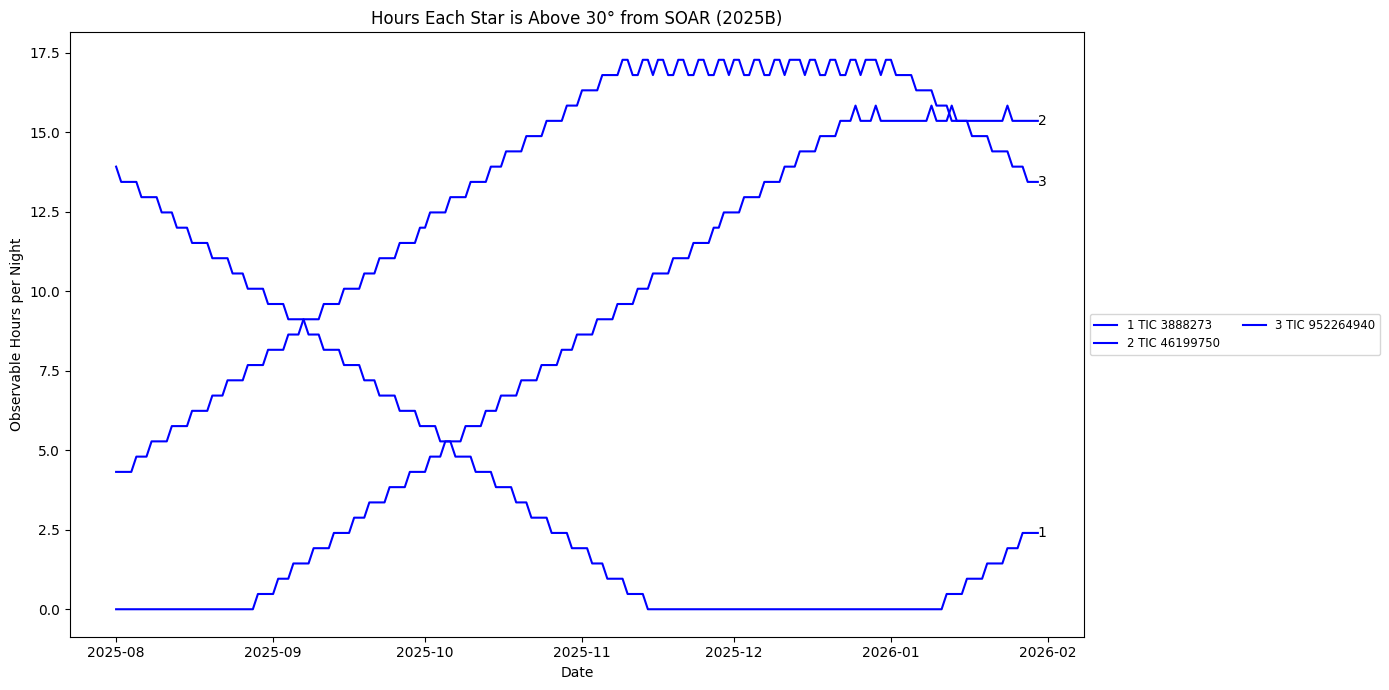

In [26]:
# Plotting
fig, ax = plt.subplots(figsize=(14, 7))
cnt=0
for name in visibility:
    if np.all(np.isclose(visibility[name], 0)):
      print(str(name)+' not visible.')
    else:
      cnt+=1
      ax.plot(date_range.datetime, visibility[name], label=str(cnt)+' '+str(name),color='b')
      plt.text(date_range.datetime[-1], visibility[name][-1], str(cnt), va='center')

ax.set_title("Hours Each Star is Above 30° from SOAR (2025B)")
ax.set_xlabel("Date")
ax.set_ylabel("Observable Hours per Night")
#ax.set_ylim(0, 12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

# Per night

Choose which night you are interested

In [79]:
# Define the night of May 18, 2025
night = Time("2025-05-19 00:00:00") # we use the next day here - midnight

In [80]:
day = (night.datetime - timedelta(days=1)).strftime("%Y-%m-%d")

In [81]:
hour_grid = np.linspace(21, 36, 100)
times = night + (hour_grid - 24) * u.hour
local_times = [t.datetime + timedelta(hours=-4) for t in times]
altaz_frame = AltAz(obstime=times, location=soar_location)

The first thing we need is the sunset and sunrise times.

In [82]:
# Get Sun altitude over the night
sun_altaz = get_sun(times).transform_to(altaz_frame)
sun_altitudes = sun_altaz.alt.deg

# Find sunset and sunrise: when Sun crosses -0.833 deg
sun_below = sun_altitudes < -0.833
crossings = np.where(np.diff(sun_below.astype(int)) != 0)[0]

# Get sunset/sunrise times
sun_events = []
for i in crossings:
    t1, t2 = times[i], times[i+1]
    a1, a2 = sun_altitudes[i], sun_altitudes[i+1]
    frac = (-0.833 - a1) / (a2 - a1)
    event_time = t1 + frac * (t2 - t1)
    sun_events.append(event_time)

# Print results
if len(sun_events) == 2:
    sunset, sunrise = sun_events
    print(f"Sunset (−0.833°): {sunset.iso}")
    print(f"Sunrise (−0.833°): {sunrise.iso}")
elif len(sun_events) == 1:
    print(f"Only one event found (sunset or sunrise): {sun_events[0].iso}")
else:
    print("No sunrise/sunset detected (polar night or day?)")

Sunset (−0.833°): 2025-05-18 21:55:12.810
Sunrise (−0.833°): 2025-05-19 11:23:54.809


remenber to select calibration stars if you are doing spectroscopy

In [84]:
flag_spec = 1
standard_star =[('LTT3218', '08:41:32.37',  '-32:56:32.9')]

If you are sharing the night with someone you can hightlight a region of the night.

In [85]:
flag_window = 1
# Define UTC times
start_utc = datetime(2025, 5, 19, 8, 7)
end_utc = datetime(2025, 5, 19, 9, 22)

# Convert to SOAR local time (UTC−4)
start_local = start_utc - timedelta(hours=4)
end_local = end_utc - timedelta(hours=4)

Each telescope has a lower limit below which it cannot observe. For SOAR this limit is 30 degrees.

In [86]:
# Identify stars below thresholds
never_above_0 = []
never_above_30 = []
star_list=stars_data
for name, ra_str, dec_str in star_list:
    coord = SkyCoord(ra=ra_str, dec=dec_str, unit=(u.hourangle, u.deg))
    altaz = coord.transform_to(altaz_frame)
    max_alt = np.max(altaz.alt.deg)

    if max_alt <= 0:
        never_above_0.append((name, max_alt))
    elif max_alt < 30:
        never_above_30.append((name, max_alt))

# Print results
print("Stars that never rise above the horizon (alt ≤ 0°):")
for name, alt in never_above_0:
    print(f"{name} — Max Altitude: {alt:.1f}°")

print("\nStars that never rise above 30° altitude:")
for name, alt in never_above_30:
    print(f"{name} — Max Altitude: {alt:.1f}°")

Stars that never rise above the horizon (alt ≤ 0°):
TIC 88564975 — Max Altitude: -1.7°
TIC 103222871 — Max Altitude: -16.0°
TIC 950570354 — Max Altitude: -12.6°

Stars that never rise above 30° altitude:
TIC 1101327387 — Max Altitude: 29.3°
TIC 1881564044 — Max Altitude: 13.2°


I like to put my star in different colors, but you can do numbers as in the semester example.

In [83]:
cores = ['firebrick','r','orangered','orange', 'yellow', 'chartreuse','g','lime', 'c','deepskyblue','royalblue','b','blueviolet','violet','m','pink']
cor=cores*5

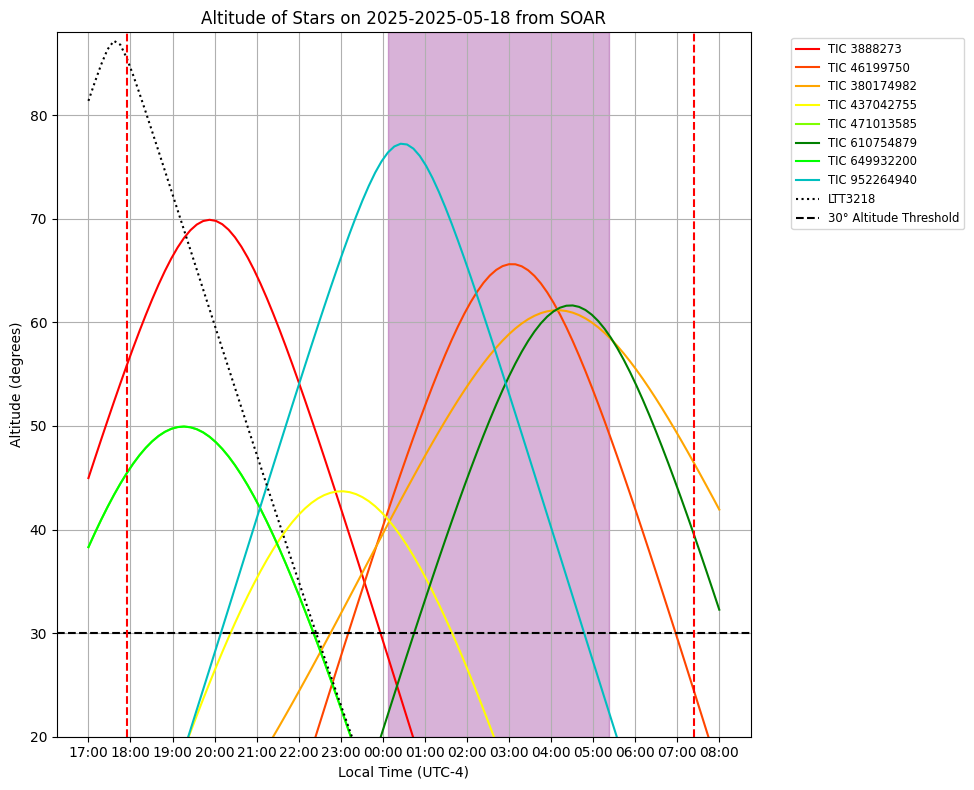

In [87]:
# Plot
plt.figure(figsize=(10, 8))
cnt=0 # is here for the colors
for name, ra_str, dec_str in stars_data:
    coord = SkyCoord(ra=ra_str, dec=dec_str, unit=(u.hourangle, u.deg))
    altaz = coord.transform_to(altaz_frame)
    max_alt = np.max(altaz.alt.deg)
    if max_alt > 30:
      cnt+=1
      plt.plot(local_times, altaz.alt.deg, label=name,color=cor[cnt],linestyle='-')#alpha=alp[star_list_all.index((name, ra_str, dec_str))],
if flag_spec==1:
    for name, ra_str, dec_str in standard_star:
        coord = SkyCoord(ra=ra_str, dec=dec_str, unit=(u.hourangle, u.deg))
        altaz = coord.transform_to(altaz_frame)
        plt.plot(local_times, altaz.alt.deg, label=name,color='k',linestyle=':')#alpha=alp[star_list_all.index((name, ra_str, dec_str))],

plt.axhline(30, color='k', linestyle='--', label='30° Altitude Threshold')
plt.xlabel("Local Time (UTC-4)")
plt.ylabel("Altitude (degrees)")
plt.title("Altitude of Stars on 2025-"+day+" from SOAR")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
# Get current axes
ax = plt.gca()
# Set major tick spacing
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(HourLocator(interval=1))
plt.tight_layout()
plt.ylim (20,88)
for t in sun_events:
  plt.axvline(t.datetime+ timedelta(hours=-4), color='r', linestyle='--')
if flag_window==1:
  plt.axvspan(start_local+ timedelta(hours=-4), end_local, color='purple', alpha=0.3, label='Observation Window')
plt.show()